## Hyperparameter search

This stage performs a grid search usign Spark to find the best model for the HLF classifier. We achieve this by training multiple Keras model in parallel.

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.1
* *Platform*: CentOS 7, Python 3.6
* *Spark cluster*: Analytix

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.1-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
pyspark_python = "<path to python>/bin/python"

from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("3-Hyperparameter search") \
        .master("yarn") \
        .config("spark.driver.memory","8g") \
        .config("spark.executor.memory","14g") \
        .config("spark.executor.cores","8") \
        .config("spark.executor.instances","60") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.pyspark.python",pyspark_python) \
        .getOrCreate()

In [3]:
# Check if Spark Session has been created correctly
spark

## Load train and test datasets

In [33]:
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [34]:
test_events = testDF.count()
train_events = trainDF.count()
print('There are {} events in the train dataset'.format(train_events))
print('There are {} events in the test dataset'.format(test_events))

There are 3426083 events in the train dataset
There are 856090 events in the test dataset


### Take small subset of data

In [35]:
trainDF_fraction = trainDF.sample(fraction=0.01, seed=42)
testDF_fraction = testDF.sample(fraction=0.01, seed=42)

## Convert to Pandas 

Now we will convert the dataset in a Pandas dataframe in order to be able to use keras

In [36]:
trainDF = trainDF_fraction.toPandas()
testDF = testDF_fraction.toPandas()

In [37]:
trainDF.head()

,HLF_input,encoded_label
0,"[0.00809329440432877, 0.0017148579507185722, 0...","(0.0, 0.0, 1.0)"
1,"[0.013682833697080407, 0.0021841484297045193, ...","(1.0, 0.0, 0.0)"
2,"[0.006159859158211762, 0.0034116357291298794, ...","(0.0, 0.0, 1.0)"
3,"[0.006966742424100583, 0.006391548439125299, 0...","(1.0, 0.0, 0.0)"
4,"[0.0, 0.007238627074906351, 0.7302505070656793...","(0.0, 0.0, 1.0)"


We need to convert `Dense` and `Sparse` vectors into list

In [38]:
trainDF[trainDF.columns] = trainDF[trainDF.columns].applymap(lambda x: list(x))
testDF[testDF.columns] = testDF[testDF.columns].applymap(lambda x: list(x))

In [39]:
import numpy as np

X = np.array(trainDF['HLF_input'].tolist())
y = np.array(trainDF['encoded_label'].tolist())

X_test = np.array(testDF['HLF_input'].tolist())
y_test = np.array(testDF['encoded_label'].tolist())

## Create the keras model

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

## Create the keras classifier

Wrapping our keras model into a Sklearn classifier allows us to use Sklearn grid Search. We will the distribute the grid search across executors usign Spark-Sklearn.

In [41]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

## Define the grid parameters

In [42]:
batch_size = [100,200]
epochs = [10, 30, 50]

## Number of hidden units per layer
nh_1 = [50,100,150]
nh_2 = [20,50,100]
nh_3 = [10,20,50]

In [43]:
param_grid = {'batch_size':batch_size,
              'nb_epoch':epochs,
              'nh_1':nh_1, 'nh_2':nh_2, 'nh_3':nh_3}

## Grid Search with Spark

In [44]:
from spark_sklearn.grid_search import GridSearchCV

sc = spark.sparkContext

grid = GridSearchCV(sc, estimator=model, param_grid=param_grid, cv=10, verbose=1)

In [45]:
gridSearch_result = grid.fit(X, y)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


In [46]:
# Get the parameters giving the best result
gridSearch_result.best_estimator_.get_params()

{'batch_size': 100,
 'build_fn': <function __main__.create_model>,
 'nb_epoch': 30,
 'nh_1': 150,
 'nh_2': 100,
 'nh_3': 50,
 'verbose': 0}

In [47]:
# See the performance on the test dataset 
y_pred = gridSearch_result.best_estimator_.predict_proba(X_test)

In [48]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [49]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9567080732972255, 1: 0.97124365402201, 2: 0.9557525045214036}

<IPython.core.display.Javascript object>


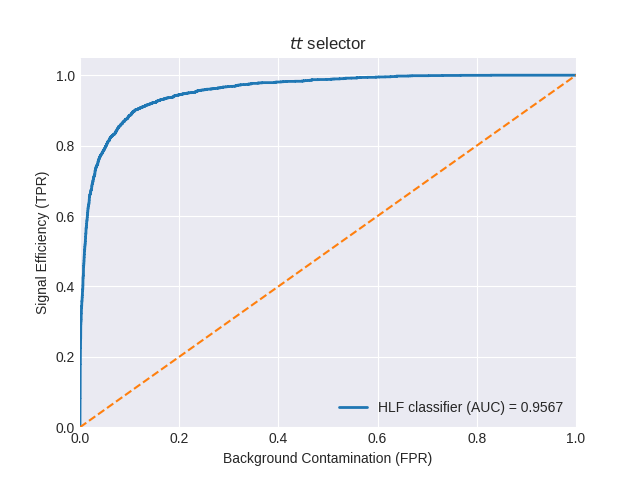

In [50]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()